# Evaluate model performance

In [1]:
# Load price data
import pandas as pd
prices = pd.read_csv('data/eurusd_minute.csv')['BidClose'].values

In [2]:
# Sample standardized data interval values
from pyexpat import model
from dataset import EncodedForexData
import numpy as np
from tqdm import tqdm

from encoders import SimpleRasterizeEncoder, GasfEncoder, RGGafEncoder

ENCODER = 'simple'

params = {
    'simple': {'encoder':SimpleRasterizeEncoder(), 'channels':1, 'relative':True},
    'gasf': {'encoder':GasfEncoder(), 'channels':1, 'relative':False},
    'rggaf': {'encoder':RGGafEncoder(), 'channels':2, 'relative':True},
}[ENCODER]

dataset = EncodedForexData(prices, 64, encoder=params['encoder'], relative=params['relative'])
encoder = params['encoder']


standardize = lambda x: (x-x.mean())/x.std()
decode = lambda x: standardize(encoder.decode(x))

data = np.concatenate([decode(mat) for mat in tqdm(dataset)], axis=0)

/home/jekabs/anaconda3/envs/ml_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 80690/80690 [00:06<00:00, 12718.44it/s]


In [3]:
from models import Generator
model = Generator(channels=params['channels'])

In [21]:
import matplotlib.pyplot as plt
def plot_cdf(data, ax=None, **kwargs):
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    if ax is None:
        ax = plt.gca()
    ax.plot(np.sort(data), y, **kwargs)

In [84]:
# Compare generated data to original data
from transforms import reverse_rel_raster, reverse_gasf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = model.to(device)
def evaluate(model, decoder, n):
    model.eval()
    sample_batches = []
    with torch.no_grad():
        noise = torch.randn(n,100).to(device)
        for i in range(n//100):
            sample_batches.append(model(noise[i*100:(i+1)*100]))

    samples = []
    for batch in tqdm(sample_batches):
        for mat in batch:
            samples.append(decoder(mat))

    samples = np.stack(samples)
    
    model_data = samples.reshape(-1)

    # for sample in model_samples[:10]:
    #     plt.plot(np.cumsum(sample))
    #     plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    plot_cdf(data, ax=ax1, label='Real')
    plot_cdf(model_data, ax=ax1, label='Generated')
    ax1.legend()

    ax2.hist(data, bins=100, density=True, label='Real', alpha=0.5)
    ax2.hist(model_data, bins=100, density=True, label='Generated', alpha=0.5)
    ax2.legend()
    plt.show()
    print('KS test:', kstest(data, model_data))

100%|██████████| 10/10 [00:00<00:00, 13.59it/s]


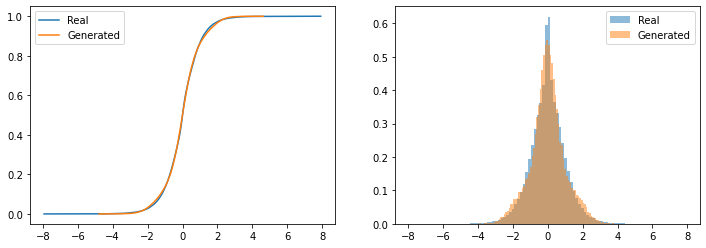

KS test: KstestResult(statistic=0.014032808820795606, pvalue=3.0461454952748345e-11)


100%|██████████| 10/10 [00:00<00:00, 12.97it/s]


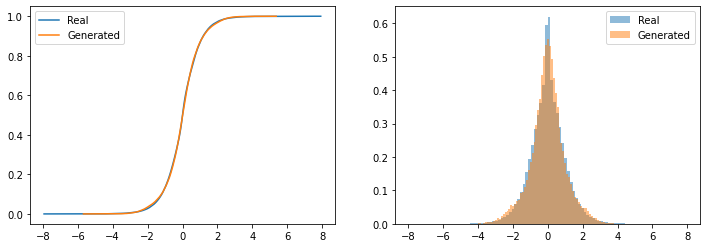

KS test: KstestResult(statistic=0.01476849284297932, pvalue=2.08917059650676e-12)


100%|██████████| 10/10 [00:00<00:00, 12.36it/s]


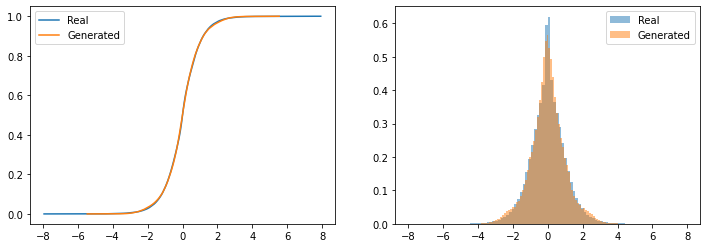

KS test: KstestResult(statistic=0.012868146997769225, pvalue=1.6016448419654195e-09)


100%|██████████| 10/10 [00:00<00:00, 13.42it/s]


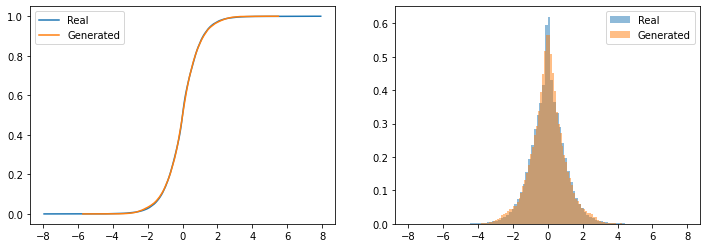

KS test: KstestResult(statistic=0.011431646192217038, pvalue=1.323770443864784e-07)


100%|██████████| 10/10 [00:00<00:00, 14.07it/s]


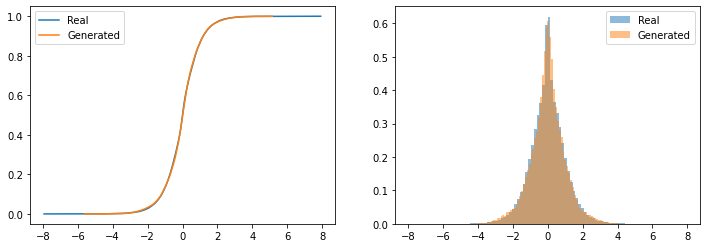

KS test: KstestResult(statistic=0.013343244593505998, pvalue=3.3158235559413995e-10)


100%|██████████| 10/10 [00:00<00:00, 15.27it/s]


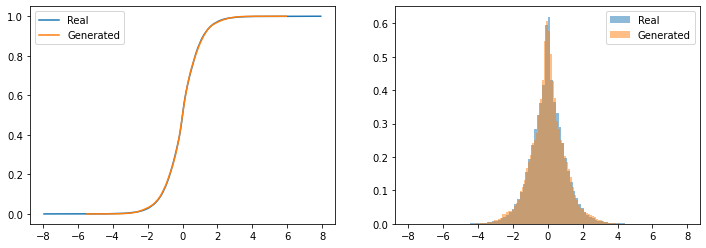

KS test: KstestResult(statistic=0.006962439196306847, pvalue=0.004337323238706287)


100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


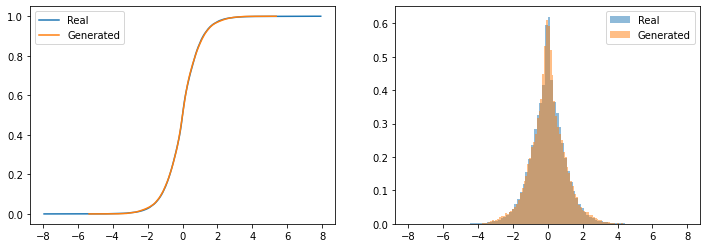

KS test: KstestResult(statistic=0.006403974702565374, pvalue=0.011149926972037445)


In [85]:
dicts = [f'experiments/simple1/model/checkpoints/{i}/g.pt' for i in range(7)]

for weights in dicts:
    model.load_state_dict(torch.load(weights))
    evaluate(model, decode, 1000)